In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib

data_dir = pathlib.Path("/content/drive/MyDrive/hackaton_dataset").with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

165


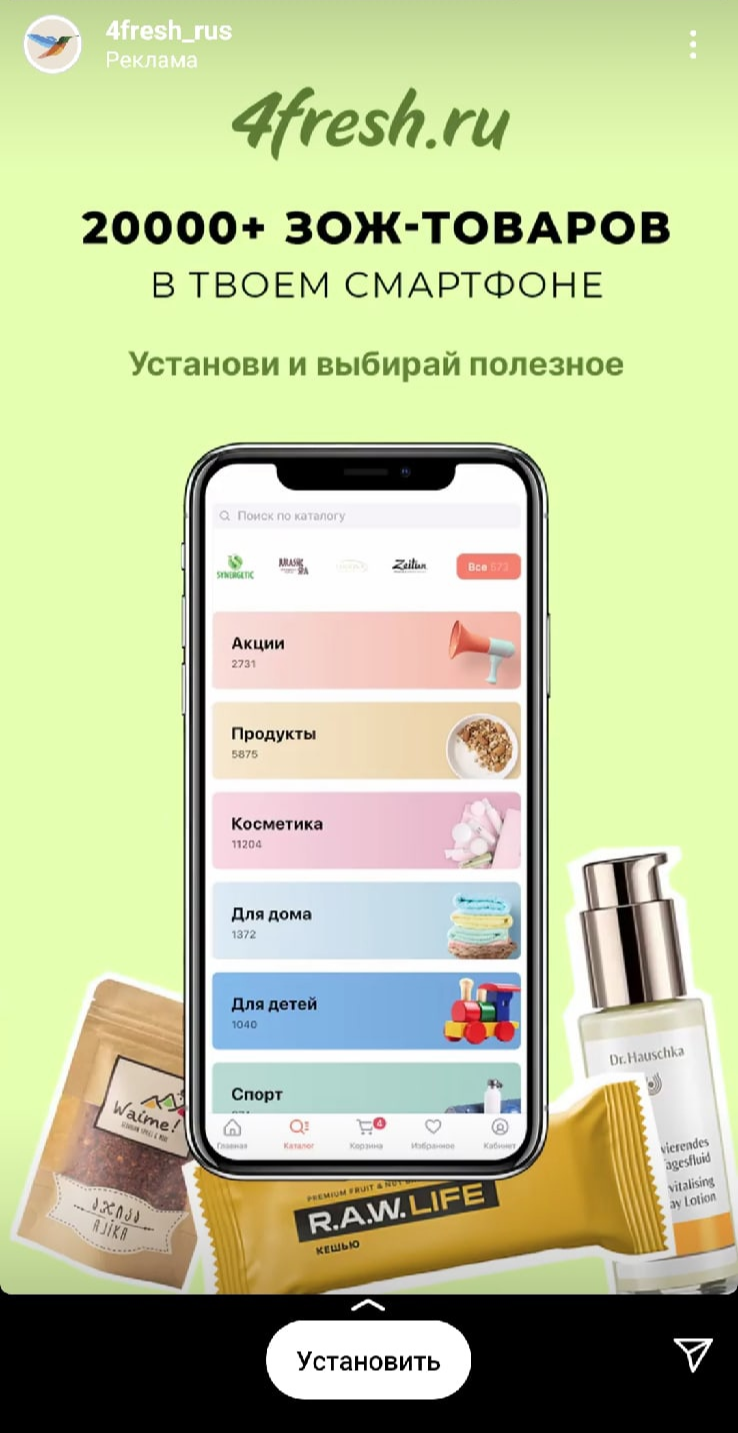

In [ ]:
injuring = list(data_dir.glob('сцены_насилия/*'))
PIL.Image.open(str(injuring[0]))

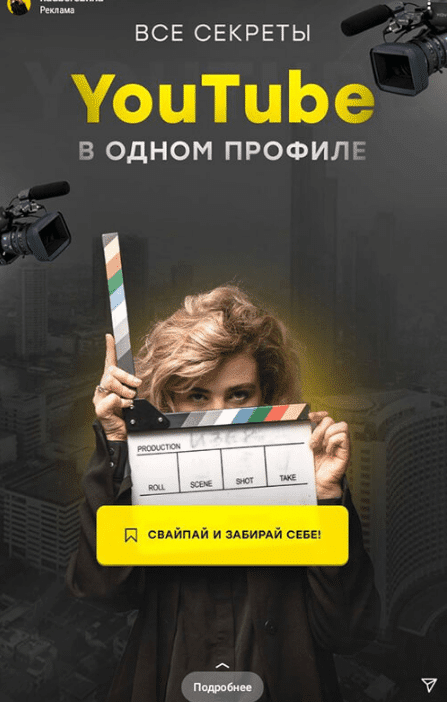

In [ ]:
PIL.Image.open(str(injuring[1]))

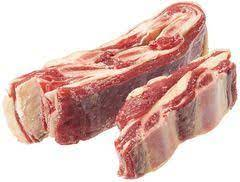

In [ ]:
tulips = list(data_dir.glob('обнаженные_фото/*'))
PIL.Image.open(str(tulips[0]))

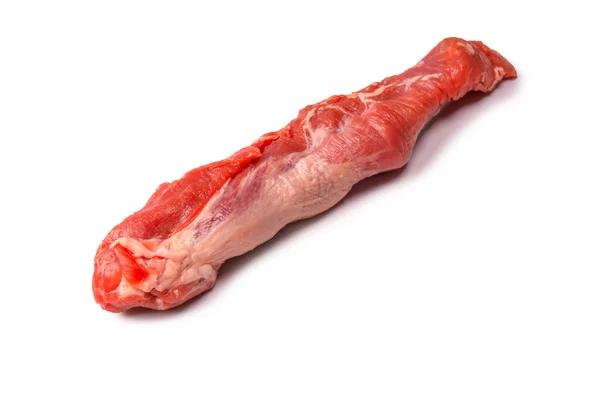

In [ ]:
PIL.Image.open(str(tulips[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 200 files belonging to 4 classes.
Using 160 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 200 files belonging to 4 classes.
Using 40 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['нормальные фото', 'обнаженные_фото', 'сексуальные_цены', 'сцены_насилия']


In [ ]:
!pip install imageio

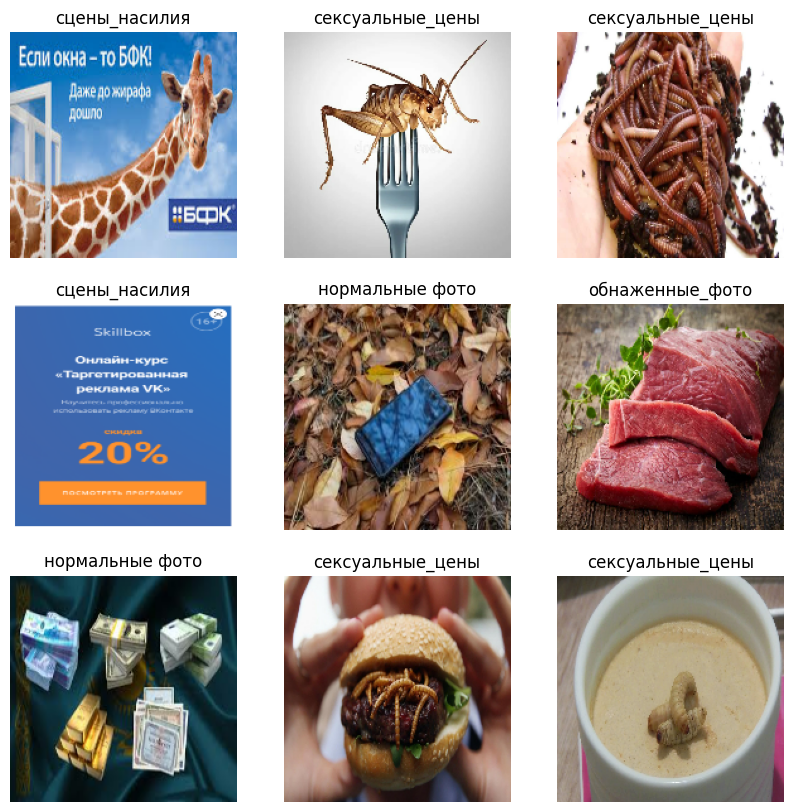

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import os
from PIL import Image

def validate_images(directory):
    for foldername in os.listdir(directory):
        folder_path = os.path.join(directory, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                        if img.format not in ['JPEG', 'PNG', 'GIF', 'BMP']:
                            img.convert('RGB').save(file_path, format='JPEG')
                except (IOError, SyntaxError) as e:
                    print(f'Bad file: {file_path} : {e}')
                    os.remove(file_path)

train_dir = "/content/drive/MyDrive/hackaton_dataset"

validate_images(train_dir)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 [==============================] - 2s 124ms/step - loss: 2.4487 - accuracy: 0.2562 - val_loss: 1.3560 - val_accuracy: 0.3500
Epoch 2/10
5/5 [==============================] - 0s 33ms/step - loss: 1.4020 - accuracy: 0.2500 - val_loss: 1.4433 - val_accuracy: 0.2500
Epoch 3/10
5/5 [==============================] - 0s 28ms/step - loss: 1.2919 - accuracy: 0.3438 - val_loss: 1.3215 - val_accuracy: 0.3000
Epoch 4/10
5/5 [==============================] - 0s 28ms/step - loss: 1.1400 - accuracy: 0.4938 - val_loss: 1.2074 - val_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 23ms/step - loss: 0.9433 - accuracy: 0.6062 - val_loss: 1.0562 - val_accuracy: 0.5500
Epoch 6/10
5/5 [==============================] - 0s 25ms/step - loss: 0.6852 - accuracy: 0.8188 - val_loss: 0.9821 - val_accuracy: 0.6750
Epoch 7/10
5/5 [==============================] - 0s 23ms/step - loss: 0.4924 - accuracy: 0.8250 - val_loss: 0.9542 - val_accuracy: 0.6500
Epoch 8/10
5/5 [==========

In [ ]:
model.save("image_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


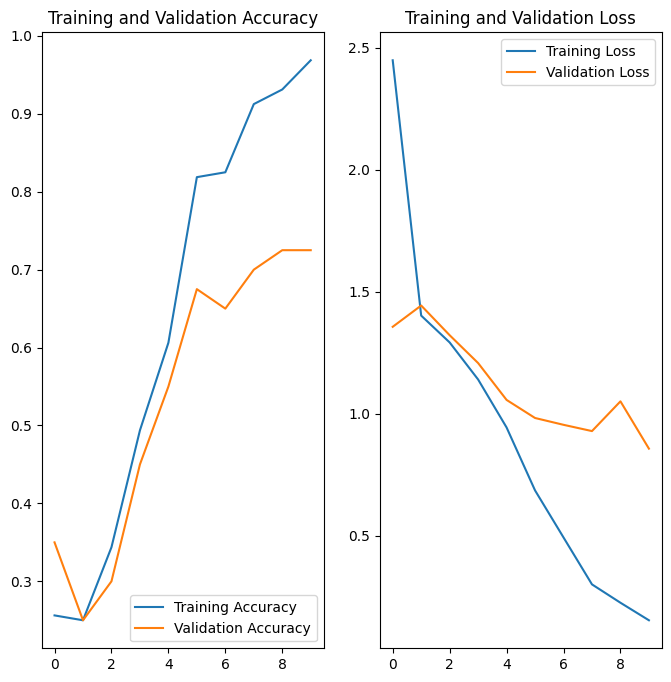

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

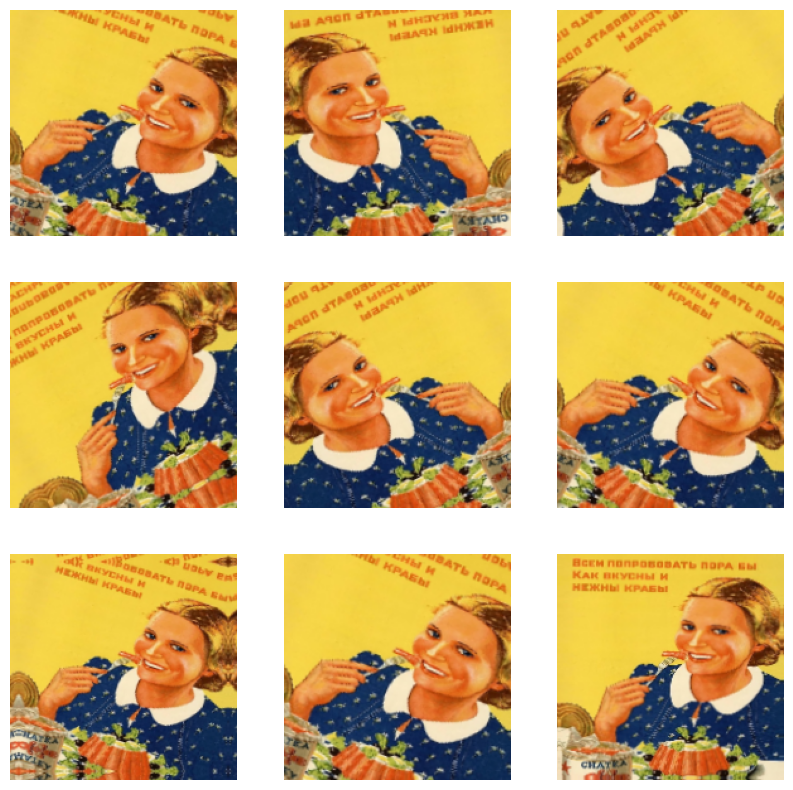

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
5/5 [==============================] - 4s 78ms/step - loss: 1.8326 - accuracy: 0.3562 - val_loss: 1.6868 - val_accuracy: 0.1500
Epoch 2/15
5/5 [==============================] - 0s 42ms/step - loss: 1.4117 - accuracy: 0.2625 - val_loss: 1.4381 - val_accuracy: 0.2250
Epoch 3/15
5/5 [==============================] - 0s 34ms/step - loss: 1.3309 - accuracy: 0.3250 - val_loss: 1.3725 - val_accuracy: 0.2500
Epoch 4/15
5/5 [==============================] - 0s 32ms/step - loss: 1.2400 - accuracy: 0.4500 - val_loss: 1.2656 - val_accuracy: 0.2750
Epoch 5/15
5/5 [==============================] - 0s 31ms/step - loss: 1.1284 - accuracy: 0.4812 - val_loss: 1.2986 - val_accuracy: 0.3000
Epoch 6/15
5/5 [==============================] - 0s 32ms/step - loss: 1.0831 - accuracy: 0.5312 - val_loss: 1.0950 - val_accuracy: 0.4750
Epoch 7/15
5/5 [==============================] - 0s 32ms/step - loss: 1.0270 - accuracy: 0.5500 - val_loss: 1.3578 - val_accuracy: 0.4000
Epoch 8/15
5/5 [===========

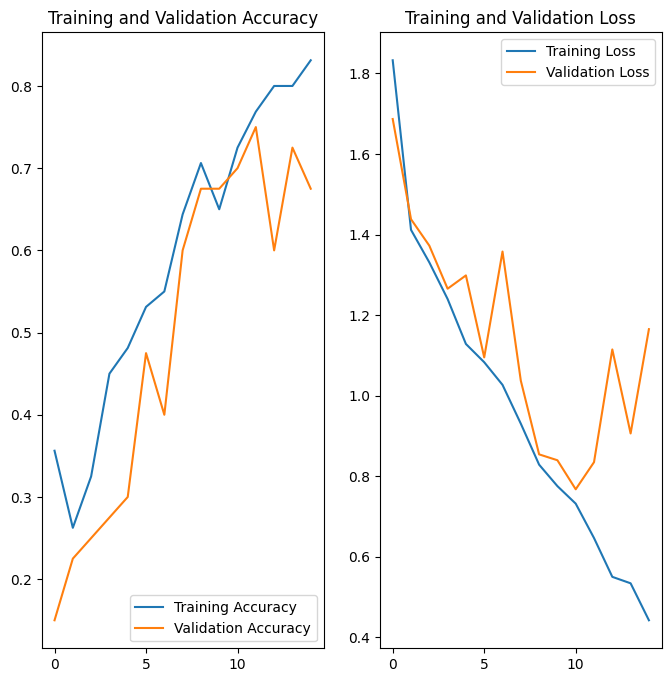

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()


for filename in uploaded.keys():
    # Load the image
    img = Image.open(filename)
    img = img.resize((img_height, img_width))  # Resize if needed
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # Get the class name and confidence
    class_name = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Print the result

    if class_name == "нормальные фото":
      if confidence > 50:
        print("нормальное фото")
      else:
        print(f"спам")
    else:
      if confidence >= 30:
       print(f"Спам, {class_name}, {confidence:.2f}%")
      else:
       print(f"нормальное фото, {class_name}, {confidence:.2f}%")
    #print(f"This image most likely belongs to {class_name} with a {confidence:.2f}% confidence.")

Saving burgerad15179945781952220614.jpg to burgerad15179945781952220614 (5).jpg
1/1 [==============================] - 0s 19ms/step
Спам, сцены_насилия, 99.97%


In [ ]:
model.save('image_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
